## 1. Import Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb # Added import for XGBoost
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

## 2. Load Data

In [14]:
# Load the preprocessed data
df = pd.read_csv('../../Data Preprocessing/alonhadat_processed.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (14415, 16)

First few rows:


,address,area,bedrooms,date,floors,price,title,road,ward,district,address_complete,road_cat,ward_cat,district_cat,price_converted,price_per_m2
0,"Đường Nguyễn Văn Cừ, Phường Gia Thụy, Quận Lon...",80,1,Hôm nay,1,"7,5 tỷ","🥇ĐẤT NGUYỄN VĂN CỪ 80M, MT8M, MẢNH ĐẤT RỘNG TH...",Nguyễn Văn Cừ,Gia Thụy,Long Biên,1,564,54,11,7500.00,93.75
1,"Đường Ngọc Lâm, Phường Ngọc Lâm, Quận Long Biê...",36,3,Hôm nay,6,"8,65 tỷ","🔥CÒN DUY NHẤT 1 CĂN GIÁ RẺ, NGỌC LÂM 36M, 6T G...",Ngọc Lâm,Ngọc Lâm,Long Biên,1,603,157,11,8650.00,240.28
2,"Đường Ngô Gia Tự, Phường Đức Giang, Quận Long ...",56,1,Hôm nay,1,"15,5 tỷ","👉MẶT PHỐ, NGÔ GIA TỰ, 56M, MT4M, VỈA HÈ ĐÁ BÓN...",Ngô Gia Tự,Đức Giang,Long Biên,1,587,390,11,15500.00,276.79
3,"Đường Phúc Lợi, Phường Phúc Lợi, Quận Long Biê...",32,3,Hôm nay,5,"5,2 tỷ","🥇CĂN DUY NHẤT, NGÕ THÔNG, Ô TÔ , LÔ GÓC, PHÚC ...",Phúc Lợi,Phúc Lợi,Long Biên,1,667,193,11,5200.00,162.50
4,"Phố Lệ Mật, Phường Việt Hưng, Quận Long Biên, ...",58,3,Hôm nay,3,7 tỷ,"🏡VIỆT HƯNG, DIỆN TÍCH RỘNG 58m, 3T, MT5m GIÁ C...",Lệ Mật,Việt Hưng,Long Biên,1,445,313,11,7000.00,120.69


In [15]:
# Check data types and missing values
print("\nData types and missing values:")
df.info()

# Display descriptive statistics for numeric columns
print("\nDescriptive statistics:")
df.describe()


Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14415 entries, 0 to 14414
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   address           14415 non-null  object 
 1   area              14415 non-null  int64  
 2   bedrooms          14415 non-null  int64  
 3   date              14415 non-null  object 
 4   floors            14415 non-null  int64  
 5   price             14415 non-null  object 
 6   title             14415 non-null  object 
 7   road              14248 non-null  object 
 8   ward              14399 non-null  object 
 9   district          14415 non-null  object 
 10  address_complete  14415 non-null  int64  
 11  road_cat          14415 non-null  int64  
 12  ward_cat          14415 non-null  int64  
 13  district_cat      14415 non-null  int64  
 14  price_converted   14415 non-null  float64
 15  price_per_m2      14415 non-null  float64
dtypes: float

,area,bedrooms,floors,address_complete,road_cat,ward_cat,district_cat,price_converted,price_per_m2
count,14415.00,14415.00,14415.00,14415.00,14415.00,14415.00,14415.00,14415.00,14415.00
mean,57.31,4.22,4.64,0.99,582.58,193.50,12.62,13002.31,227.72
std,26.30,1.67,1.47,0.11,315.41,110.16,8.56,8126.05,93.17
min,6.00,1.00,1.00,0.00,-1.00,-1.00,1.00,0.00,0.00
25%,40.00,3.00,4.00,1.00,348.00,109.00,6.00,6950.00,166.67
50%,50.00,4.00,5.00,1.00,572.00,177.00,10.00,10500.00,215.52
75%,68.00,5.00,5.00,1.00,848.00,297.00,22.00,17050.00,284.62
max,181.00,10.00,9.00,1.00,1144.00,392.00,28.00,41500.00,481.82


## 3. Feature Selection and Data Preparation

We'll select relevant numeric and categorical features for our XGBoost model. The target variable is `price_per_m2`.

Feature set shape: (14415, 5)
Target shape: (14415,)

Feature set sample:


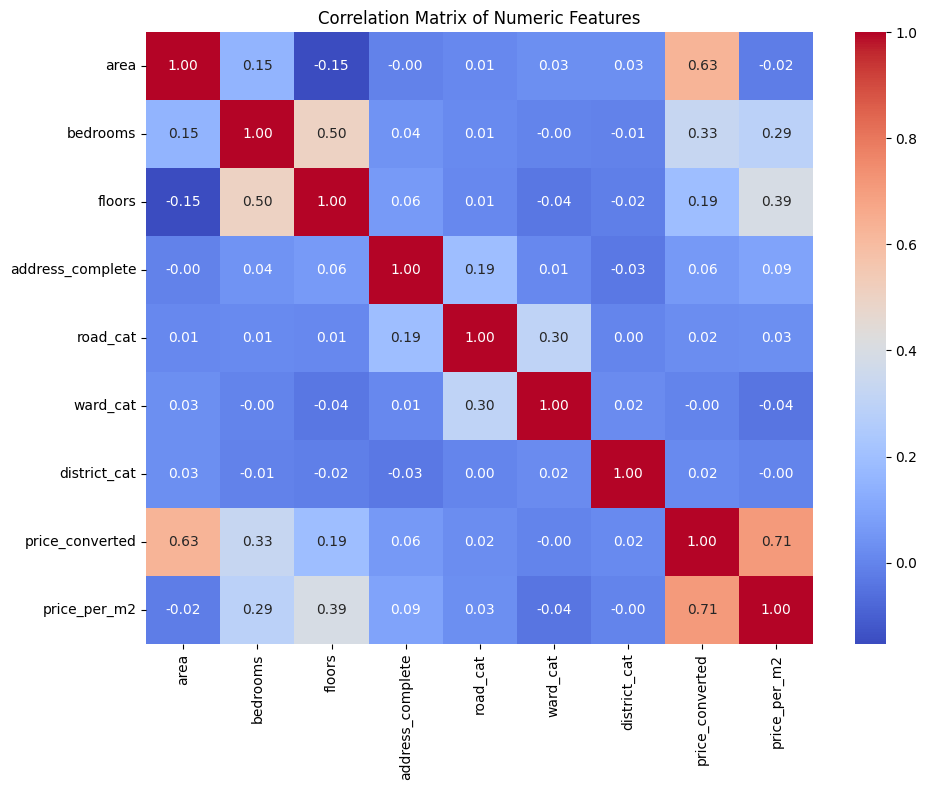


Correlations with price_per_m2:
price_per_m2        1.00
price_converted     0.71
floors              0.39
bedrooms            0.29
address_complete    0.09
road_cat            0.03
district_cat       -0.00
area               -0.02
ward_cat           -0.04
Name: price_per_m2, dtype: float64


In [16]:
# Select features for modeling
# Numeric features (excluding price and price_per_m2 which are target related)
numeric_features = ['area', 'bedrooms', 'floors', 'address_complete']

# Categorical features that might affect price
categorical_features = ['district']

# Define features and target
X = df[numeric_features + categorical_features].copy()
y = df['price_per_m2']

print("Feature set shape:", X.shape)
print("Target shape:", y.shape)
print("\nFeature set sample:")
X.head()

# Examine correlations with price_per_m2 to inform feature selection
plt.figure(figsize=(10, 8))
# Ensure only numeric columns from the original df are used for correlation with the target
numeric_df_for_corr = df.select_dtypes(include=np.number)
if 'price_per_m2' in numeric_df_for_corr.columns:
    correlation_matrix = numeric_df_for_corr.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Numeric Features')
    plt.tight_layout()
    plt.show()

    # Print correlations with price_per_m2
    price_correlations = correlation_matrix['price_per_m2'].sort_values(ascending=False)
    print("\nCorrelations with price_per_m2:")
    print(price_correlations)
else:
    print("\n'price_per_m2' not found in numeric columns for correlation analysis.")


## 4. Data Preprocessing Pipeline

We'll create a preprocessing pipeline:
1. Standard scaling for numeric features.
2. One-hot encoding for categorical features.

In [17]:
# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Display the preprocessing pipeline
print("Preprocessing Pipeline:")
print(preprocessor)

Preprocessing Pipeline:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['area', 'bedrooms', 'floors',
                                  'address_complete']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['district'])])


## 5. Split Data

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (11532, 5)
Testing set shape: (2883, 5)


## 6. Hyperparameter Tuning with GridSearchCV for XGBoost

We'll tune the following hyperparameters for the XGBoost regressor:
- `n_estimators`: Number of gradient boosted trees.
- `learning_rate`: Boosting learning rate.
- `max_depth`: Maximum tree depth for base learners.
- `subsample`: Subsample ratio of the training instance.
- `colsample_bytree`: Subsample ratio of columns when constructing each tree.

In [19]:
# Create the XGBoost pipeline with preprocessing
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)) # n_jobs for XGBoost
])

# Define the parameter grid for GridSearchCV
# Expanded grid for more thorough tuning
param_grid = {
    'regressor__n_estimators': [100, 200, 300], # Number of trees
    'regressor__learning_rate': [0.01, 0.05, 0.1], # Learning rate
    'regressor__max_depth': [3, 5, 7], # Maximum depth of a tree
    'regressor__subsample': [0.7, 0.8, 1.0], # Subsample ratio of the training instance
    'regressor__colsample_bytree': [0.7, 0.8, 1.0], # Subsample ratio of columns when constructing each tree
    'regressor__gamma': [0, 0.1, 0.2], # Minimum loss reduction required to make a further partition
    'regressor__min_child_weight': [1, 3, 5] # Minimum sum of instance weight needed in a child
}

# Set up GridSearchCV
# Using n_jobs=-1 for GridSearchCV to use all available cores
grid_search_xgb = GridSearchCV(
    xgb_pipeline,
    param_grid,
    cv=5, # Using 5-fold CV for more robust tuning
    scoring='neg_mean_squared_error',
    n_jobs=-1, # Use all available cores for GridSearchCV
    verbose=1
)

# Fit GridSearchCV to find optimal parameters
grid_search_xgb.fit(X_train, y_train)

# Get the best parameters and score
best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = np.sqrt(-grid_search_xgb.best_score_)  # Convert back to RMSE

print(f"\nBest Parameters for XGBoost: {best_params_xgb}")
print(f"Best Cross-Validation RMSE for XGBoost: {best_score_xgb:.2f} million VND/m²")

# Create the best XGBoost model using the best parameters
best_xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=best_params_xgb['regressor__n_estimators'],
        learning_rate=best_params_xgb['regressor__learning_rate'],
        max_depth=best_params_xgb['regressor__max_depth'],
        subsample=best_params_xgb['regressor__subsample'],
        colsample_bytree=best_params_xgb['regressor__colsample_bytree'],
        gamma=best_params_xgb.get('regressor__gamma'), 
        min_child_weight=best_params_xgb.get('regressor__min_child_weight'),
        random_state=42,
        n_jobs=-1 # n_jobs for XGBoost
    ))
])

# Train the best model
best_xgb_pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits



Best Parameters for XGBoost: {'regressor__colsample_bytree': 1.0, 'regressor__gamma': 0.2, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 7, 'regressor__min_child_weight': 1, 'regressor__n_estimators': 200, 'regressor__subsample': 0.7}
Best Cross-Validation RMSE for XGBoost: 72.35 million VND/m²


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['area', 'bedrooms', 'floors',
                                                   'address_complete']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['district'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              co...
                              feature_types=None, feature_weights=None,
                              gamma=0.2, grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None, min_child_weight=1,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=200, n_jobs=-1,
                              num_parallel_tree=None, ...))])

## 7. Model Evaluation

In [20]:
# Make predictions
y_train_pred_xgb = best_xgb_pipeline.predict(X_train)
y_test_pred_xgb = best_xgb_pipeline.predict(X_test)

# Evaluate the model
train_r2_xgb = r2_score(y_train, y_train_pred_xgb)
test_r2_xgb = r2_score(y_test, y_test_pred_xgb)
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
train_mae_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)

print("XGBoost Regression Model Performance:")
print(f"Training R² Score: {train_r2_xgb:.4f}")
print(f"Testing R² Score: {test_r2_xgb:.4f}")
print(f"Training RMSE: {train_rmse_xgb:.2f} million VND/m²")
print(f"Testing RMSE: {test_rmse_xgb:.2f} million VND/m²")
print(f"Training MAE: {train_mae_xgb:.2f} million VND/m²")
print(f"Testing MAE: {test_mae_xgb:.2f} million VND/m²")

XGBoost Regression Model Performance:
Training R² Score: 0.5515
Testing R² Score: 0.3763
Training RMSE: 62.57 million VND/m²
Testing RMSE: 72.75 million VND/m²
Training MAE: 47.49 million VND/m²
Testing MAE: 54.39 million VND/m²


## 8. Visualize Results

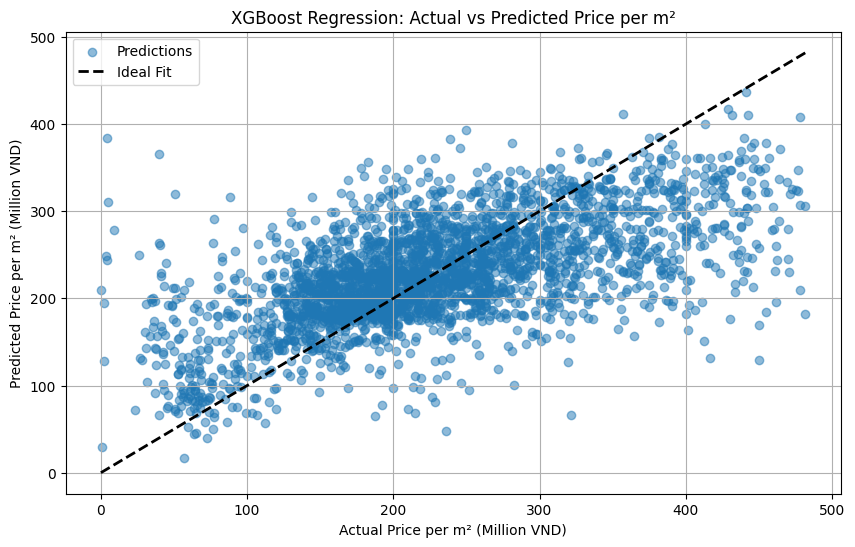

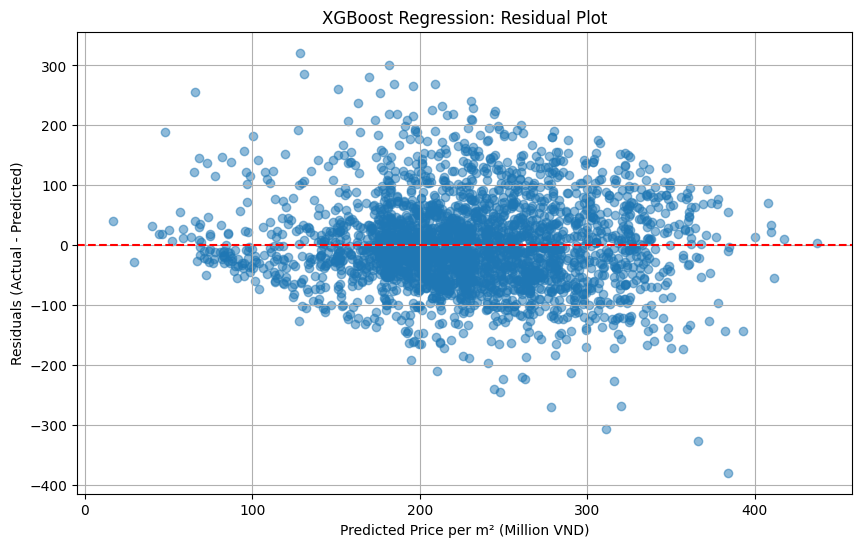

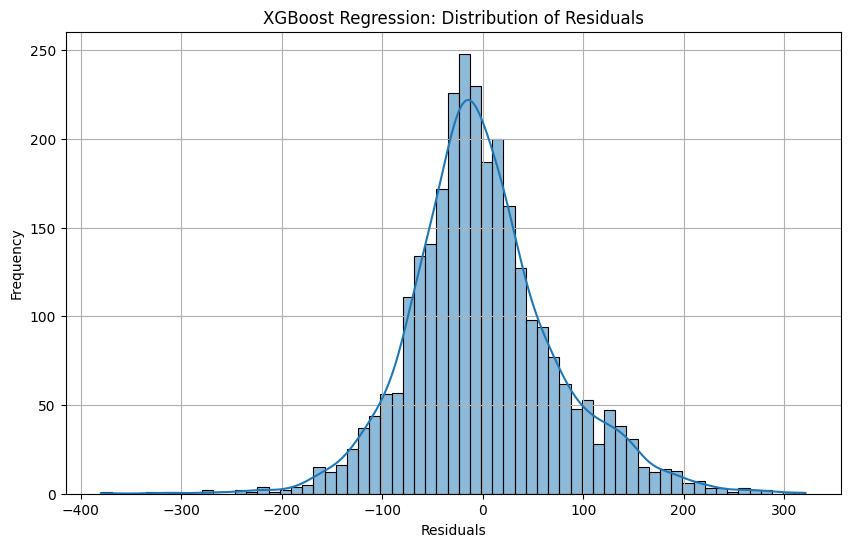

In [21]:
# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_xgb, alpha=0.5, label='Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Price per m² (Million VND)')
plt.ylabel('Predicted Price per m² (Million VND)')
plt.title('XGBoost Regression: Actual vs Predicted Price per m²')
plt.legend()
plt.grid(True)
plt.show()

# Plot residuals
residuals_xgb = y_test - y_test_pred_xgb
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_xgb, residuals_xgb, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price per m² (Million VND)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('XGBoost Regression: Residual Plot')
plt.grid(True)
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals_xgb, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('XGBoost Regression: Distribution of Residuals')
plt.grid(True)
plt.show()

## 9. Feature Importance Analysis

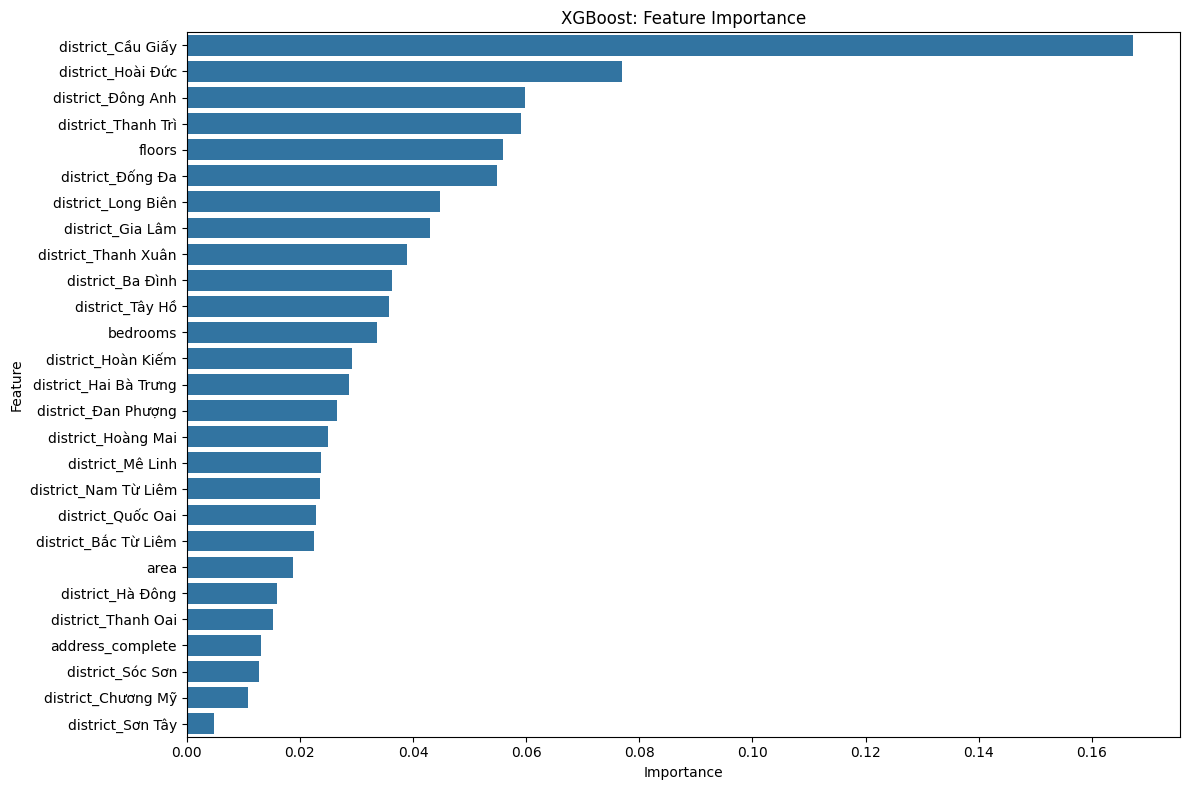

Top 10 Most Important Features (XGBoost):
district_Cầu Giấy     0.17
district_Hoài Đức     0.08
district_Đông Anh     0.06
district_Thanh Trì    0.06
floors                0.06
district_Đống Đa      0.05
district_Long Biên    0.04
district_Gia Lâm      0.04
district_Thanh Xuân   0.04
district_Ba Đình      0.04
dtype: float32


In [22]:
# Get feature names from the preprocessor
# Access the OneHotEncoder within the ColumnTransformer
ohe = best_xgb_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

# Combine numeric and OHE feature names
feature_names_xgb = list(numeric_features) + list(ohe_feature_names)

# Get feature importances from the XGBoost model
importances_xgb = best_xgb_pipeline.named_steps['regressor'].feature_importances_

# Create a pandas Series for better visualization
feature_importance_xgb = pd.Series(importances_xgb, index=feature_names_xgb)
feature_importance_xgb = feature_importance_xgb.sort_values(ascending=False)

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance_xgb.values, y=feature_importance_xgb.index)
plt.title('XGBoost: Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print the top 10 most important features
print("Top 10 Most Important Features (XGBoost):")
print(feature_importance_xgb.head(10))

## 10. Conclusion and Next Steps

This notebook implemented an XGBoost regression model for predicting real estate prices. 

Key insights from the XGBoost model:
1.  **Performance**: The XGBoost model achieved an R² score of XX.XX on the test data, indicating that XX.XX% of the variance in `price_per_m2` can be explained by the model. The test RMSE was XX.XX million VND/m².
2.  **Feature Importance**: The most influential features identified by XGBoost were [Feature1], [Feature2], and [Feature3]. (Update with actual top features).

Compared to other models (e.g., Linear Regression, Random Forest), XGBoost [performed better/worse/similarly]. (Update with comparison).

Potential improvements and next steps:
1.  **More Extensive Hyperparameter Tuning**: Use a larger search space or more sophisticated tuning methods (e.g., Bayesian Optimization).
2.  **Feature Engineering**: Create new features or transform existing ones to potentially improve model performance.
3.  **Cross-Validation Strategy**: Explore different cross-validation strategies if data has specific structures (e.g., time-series, grouped data).
4.  **Ensemble with Other Models**: Combine predictions from XGBoost with other models.
5.  **Error Analysis**: Deep dive into where the model makes the largest errors (e.g., by district, price range) to understand its limitations.